In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a2239727-7ae8-ab64-5083-67e706fd1855)


# ガウス過程潜在変数モデル（GPLVM）

In [2]:
#@title install package
!pip install gpytorch==1.5.1
!pip install watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.1/503.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.1 MB/s eta 0:00:00


In [3]:
#@title import packages
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch.nn import Parameter
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import NormalPrior
from gpytorch.mlls import VariationalELBO, PredictiveLogLikelihood

import gpytorch
sns.reset_defaults()
sns.set_context(context='talk')
colors = sns.color_palette('tab10')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
def set_seed(seed):
    import numpy as np
    import random

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(0)

## データセット

In [5]:
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"
df = pd.read_csv(URL, index_col=0)

print('data shape:', df.shape)
print('labels:', df.index.unique().tolist())

df.head()

data shape: (437, 48)
labels: ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']


,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


## モデル構築


In [6]:
K = 2
N = df.shape[0]
D = df.shape[1]

data = torch.tensor(df.values, dtype=torch.get_default_dtype())

# 転置によりYはD　x　N行列とする
y = data.t()

# capture_timeは対数変換し、[0,1]の範囲となるようにスケーリングする。
capture_time = y.new_tensor([int(cell_name.split(" ")[0])
    for cell_name in df.index.values])
time = capture_time.log2() / 6

X_prior_mean = torch.zeros(y.size(1), K)  # N x K行列

# Xの事前分布の平均の1次元目はtimeに設定する。
X_prior_mean[:, 0] = time

In [7]:
class GPLVM(ApproximateGP):
    def __init__(self, n_inducing_points, n_latent_dims,
                 n_data_dims, n_data_points):
        batch_shape = torch.Size([n_data_dims])
        # 誘導点の初期値の設定（標準正規分布からサンプリング。引数はshapeを表す）
        inducing_points = torch.randn(n_data_dims,
                                      n_inducing_points,
                                      n_latent_dims)
        # 近似事後分布の設定
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=batch_shape,
        )
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution,
            # 誘導点の位置を学習対象のパラメータとする
            learn_inducing_locations=True
        )
        super(GPLVM, self).__init__(variational_strategy)
        self.mean_module = ConstantMean(batch_shape=batch_shape)
        self.covar_module = ScaleKernel(
            RBFKernel(nu=1.5, batch_shape=batch_shape, ard_num_dims=2),
            batch_shape=batch_shape
        )
        # Xを事前分布の平均値で初期化し、パラメータとしてモデルに登録
        self.register_parameter(
            name='X',
            parameter=Parameter(X_prior_mean.clone())
            )
        # 事前分布をモデルに登録
        self.register_prior(
            name='prior_X',
            prior=NormalPrior(loc=X_prior_mean,
                              scale=torch.ones_like(X_prior_mean)),
            # 事前分布を設定するパラメータ名
            param_or_closure='X')

    def forward(self, X):
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        dist = MultivariateNormal(mean_x, covar_x)
        return dist


model = GPLVM(n_inducing_points=32, n_latent_dims=K,
              n_data_dims=D, n_data_points=N)
likelihood = GaussianLikelihood(num_tasks=D, batch_shape=torch.Size([D]))

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    y = y.cuda()

##  推論

In [8]:
model.train()
likelihood.train()

# 最適化対象のパラメータを設定
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# 目的関数の設定（gpytorch.mllsモジュールにはVariationalELBOクラスなど他にもいくつか目的関数の選択肢がある）
mll = PredictiveLogLikelihood(likelihood, model, num_data=N)

In [9]:
%%time
loss_list = []
iterator = tqdm(range(2000))
for i in iterator:
    optimizer.zero_grad()
    output = model(model.X)
    loss = -mll(output, y).sum()
    loss_list.append(loss.item())
    if not i % 500:
        print(str(loss.item()) + ", iter no: " + str(i))
    iterator.set_postfix(loss=loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()

# torch.save(model.state_dict(),"hypers.mod")

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2264.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


157.47998046875, iter no: 0
112.59231567382812, iter no: 500
108.56950378417969, iter no: 1000
106.91178131103516, iter no: 1500
CPU times: user 37.1 s, sys: 481 ms, total: 37.6 s
Wall time: 44.5 s


Text(0, 0.5, '-ELBO')

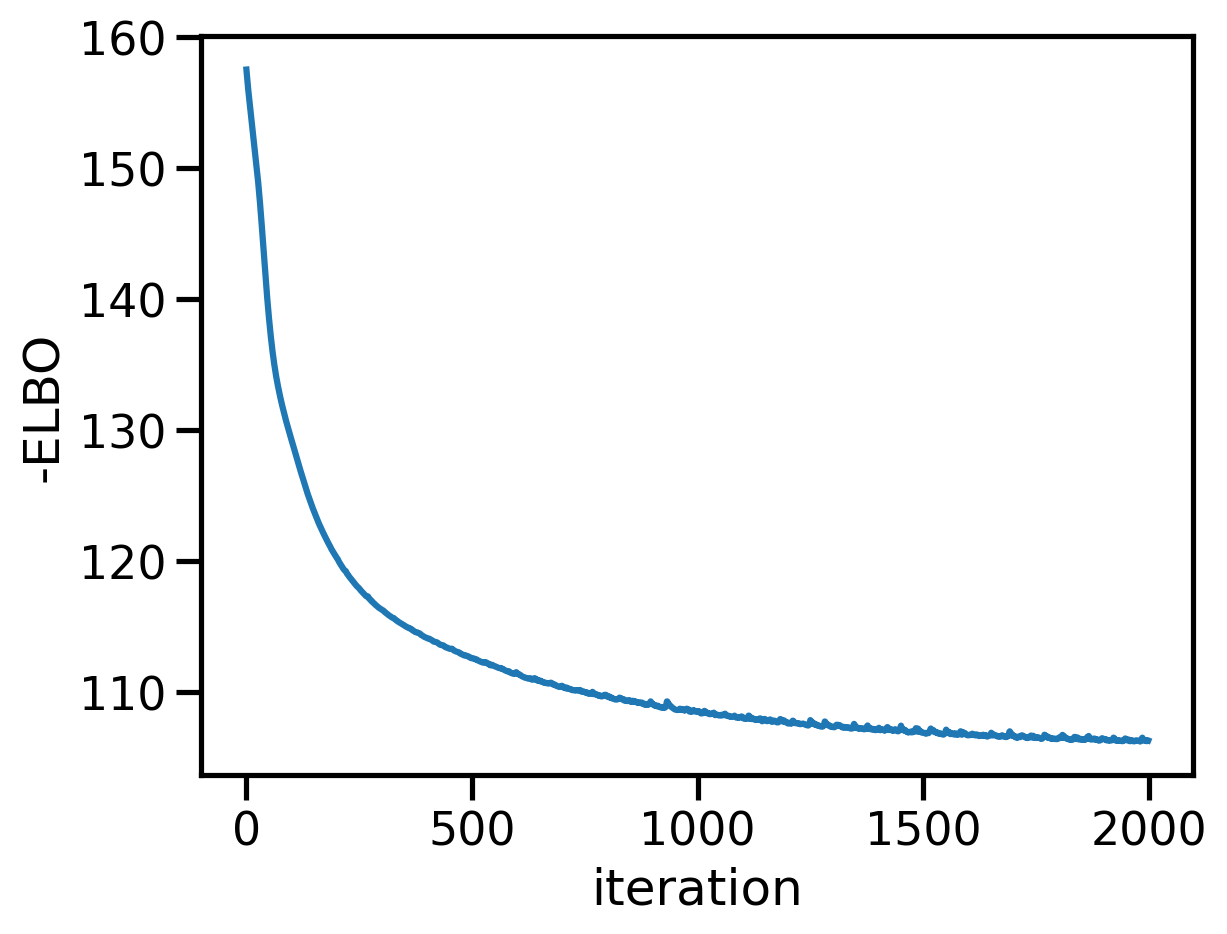

In [10]:
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('-ELBO')

## 推論結果

Text(0.5, 1.0, 'GPLVM on Single-Cell qPCR data')

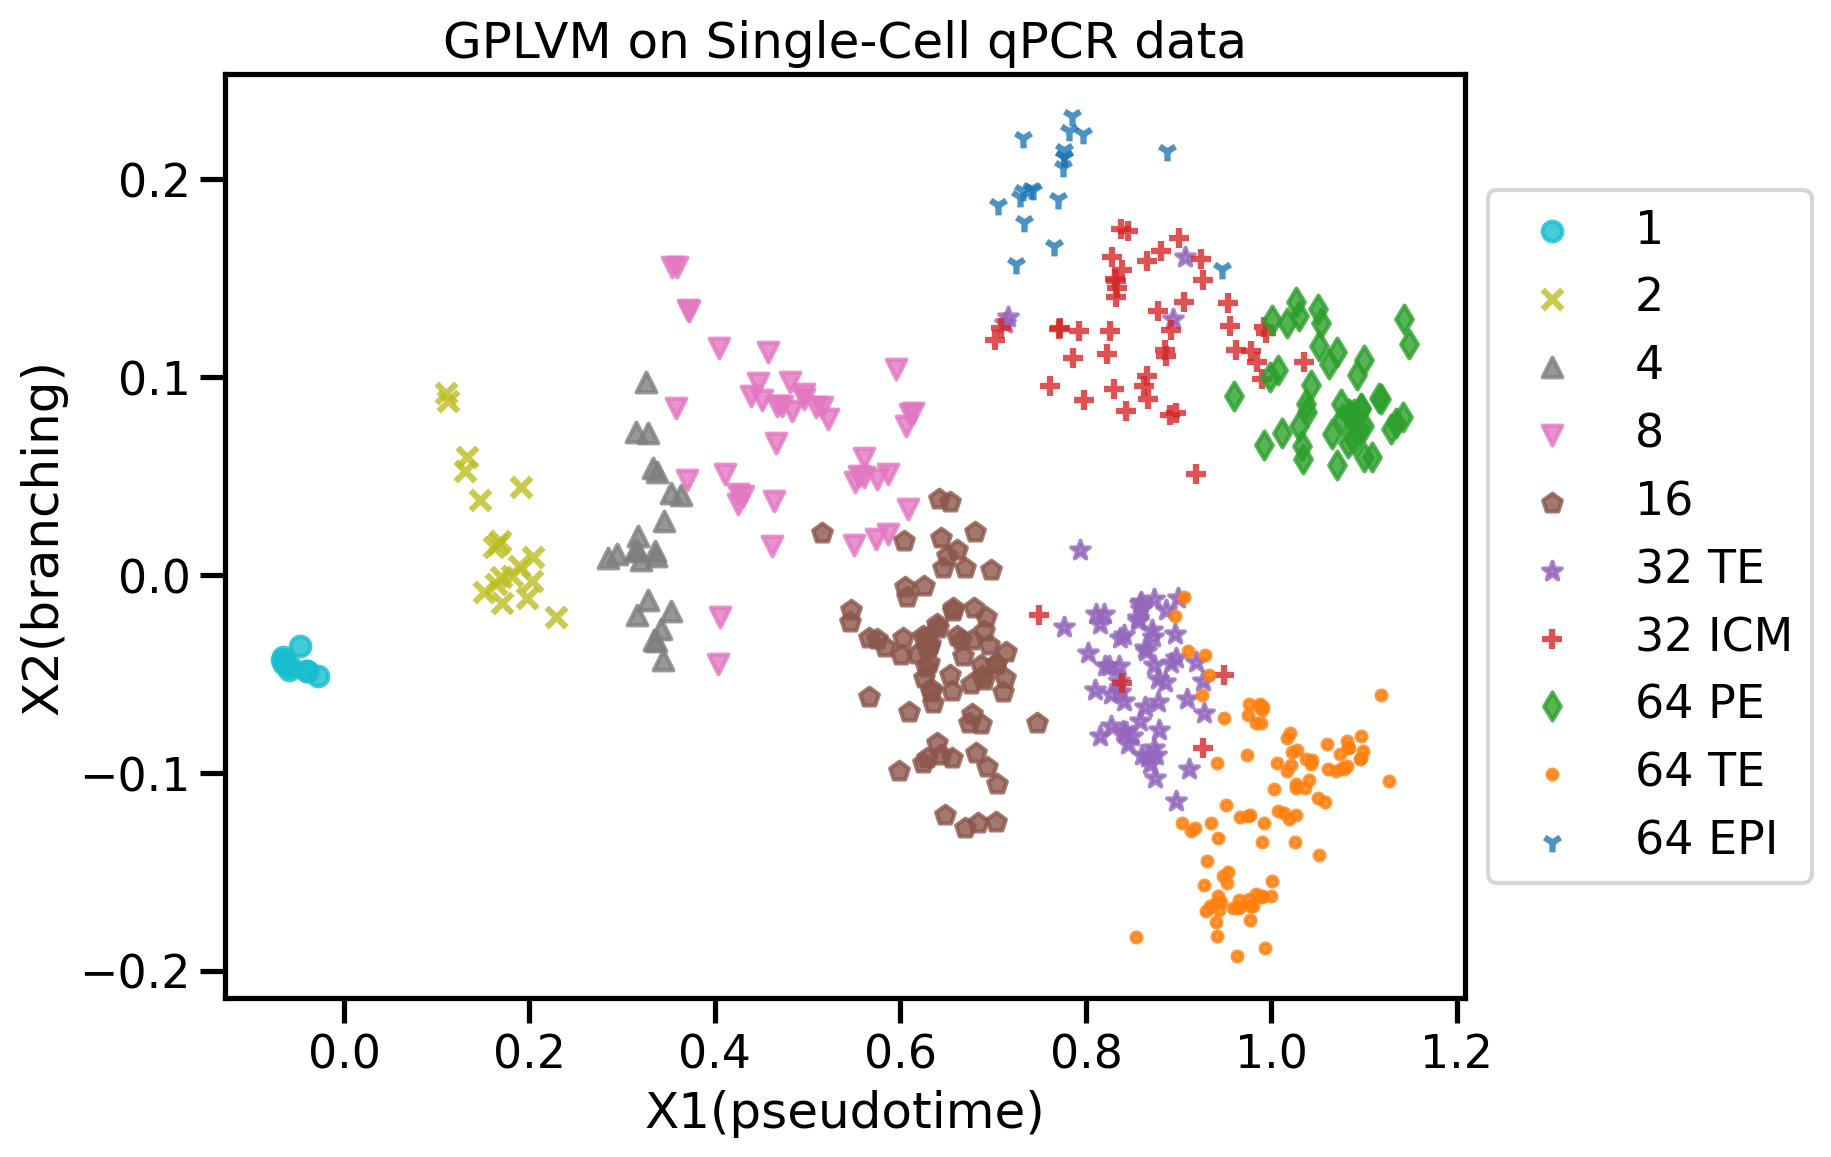

In [11]:
colors = plt.get_cmap("tab10").colors[::-1]
markers = ['o', 'x', '^', 'v', 'p', '*', '+', 'd', '.', '1']

labels = df.index.unique()
X = model.X.cpu().detach().numpy()

plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    X_i = X[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], color=colors[i], marker=markers[i], alpha=0.8, s=50, label=label)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("X1(pseudotime)")
plt.ylabel("X2(branching)")
plt.title("GPLVM on Single-Cell qPCR data")

## 他の手法との比較

Text(0.5, 1.0, 'PCA on Single-Cell qPCR data')

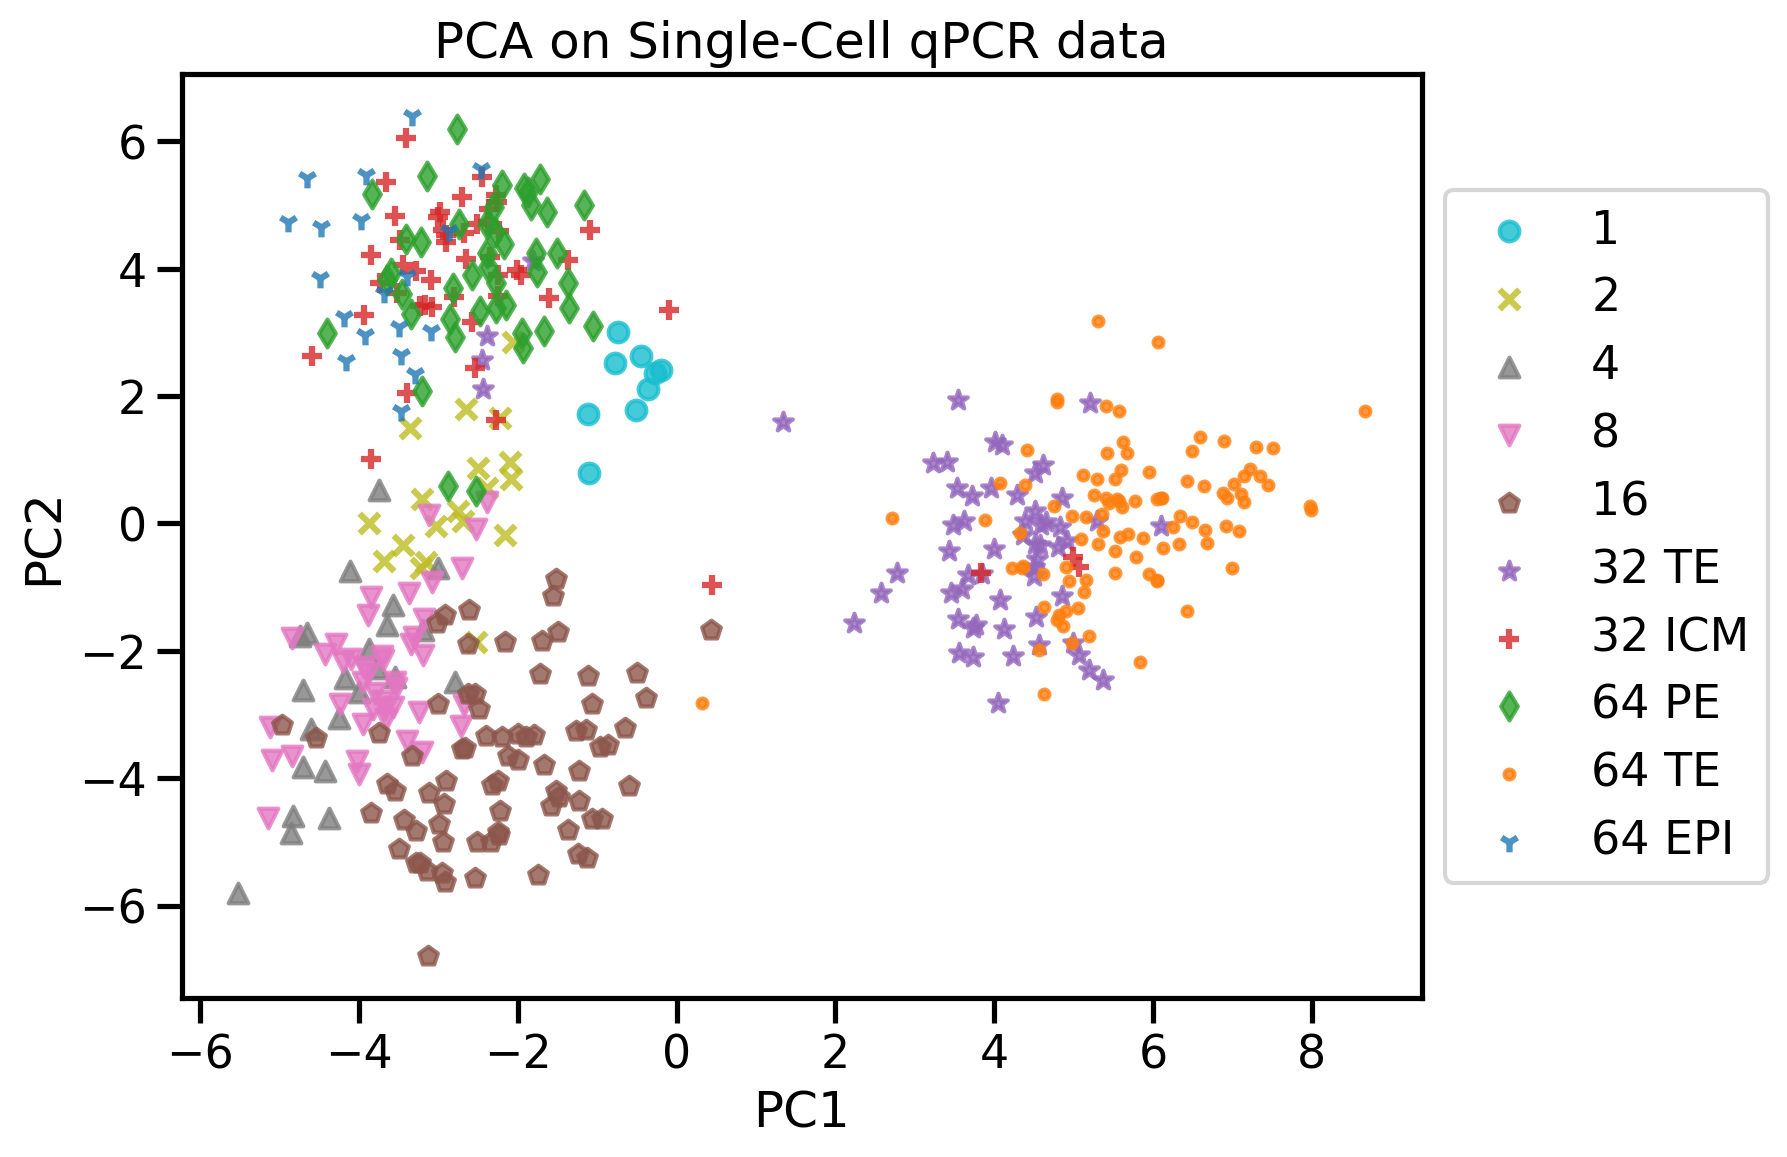

In [12]:
#@title PCA(hide)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(data)

plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

for i, label in enumerate(labels):
    X_i = X_pca[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], marker=markers[i], alpha=0.8, s=50, label=label)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Single-Cell qPCR data")

In [13]:
#@title PPCA (with capture time as prior mean)
'''
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

with pm.Model() as model:
    w = pm.Normal('w', mu=np.zeros([D, K]), sd=np.ones([D, K]), shape=[D, K])
    x = pm.Normal('x', mu=np.c_[time, np.zeros_like(time)], sd=np.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=5)
    y = pm.Normal('y', mu=w.dot(x.T), sd=sigma*np.ones([D, N]), shape=[D, N], observed=train_y.cpu().numpy())

with model:
    trace = pm.sample(2000, chains=1, random_seed=2)

x_avg = trace['x'].mean(axis=0)

plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

for i, label in enumerate(labels):
    X_i = x_avg[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)

plt.legend()
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.title("PPCA on Single-Cell qPCR data", fontsize=16)
plt.grid(True)
'''

'\nimport pymc3 as pm\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nwith pm.Model() as model:\n    w = pm.Normal(\'w\', mu=np.zeros([D, K]), sd=np.ones([D, K]), shape=[D, K])\n    x = pm.Normal(\'x\', mu=np.c_[time, np.zeros_like(time)], sd=np.ones([N, K]), shape=[N, K])\n    sigma = pm.HalfCauchy(\'sigma\', beta=5)\n    y = pm.Normal(\'y\', mu=w.dot(x.T), sd=sigma*np.ones([D, N]), shape=[D, N], observed=train_y.cpu().numpy())\n\nwith model:\n    trace = pm.sample(2000, chains=1, random_seed=2)\n\nx_avg = trace[\'x\'].mean(axis=0)\n\nplt.figure(figsize=(8, 6))\ncolors = plt.get_cmap("tab10").colors[::-1]\nlabels = df.index.unique()\n\nfor i, label in enumerate(labels):\n    X_i = x_avg[df.index == label]\n    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)\n\nplt.legend()\nplt.xlabel("PC1", fontsize=14)\nplt.ylabel("PC2", fontsize=14)\nplt.title("PPCA on Single-Cell qPCR data", fontsize=16)\nplt.grid(True)\n'

Text(0.5, 1.0, 't-SNE on Single-Cell qPCR data')

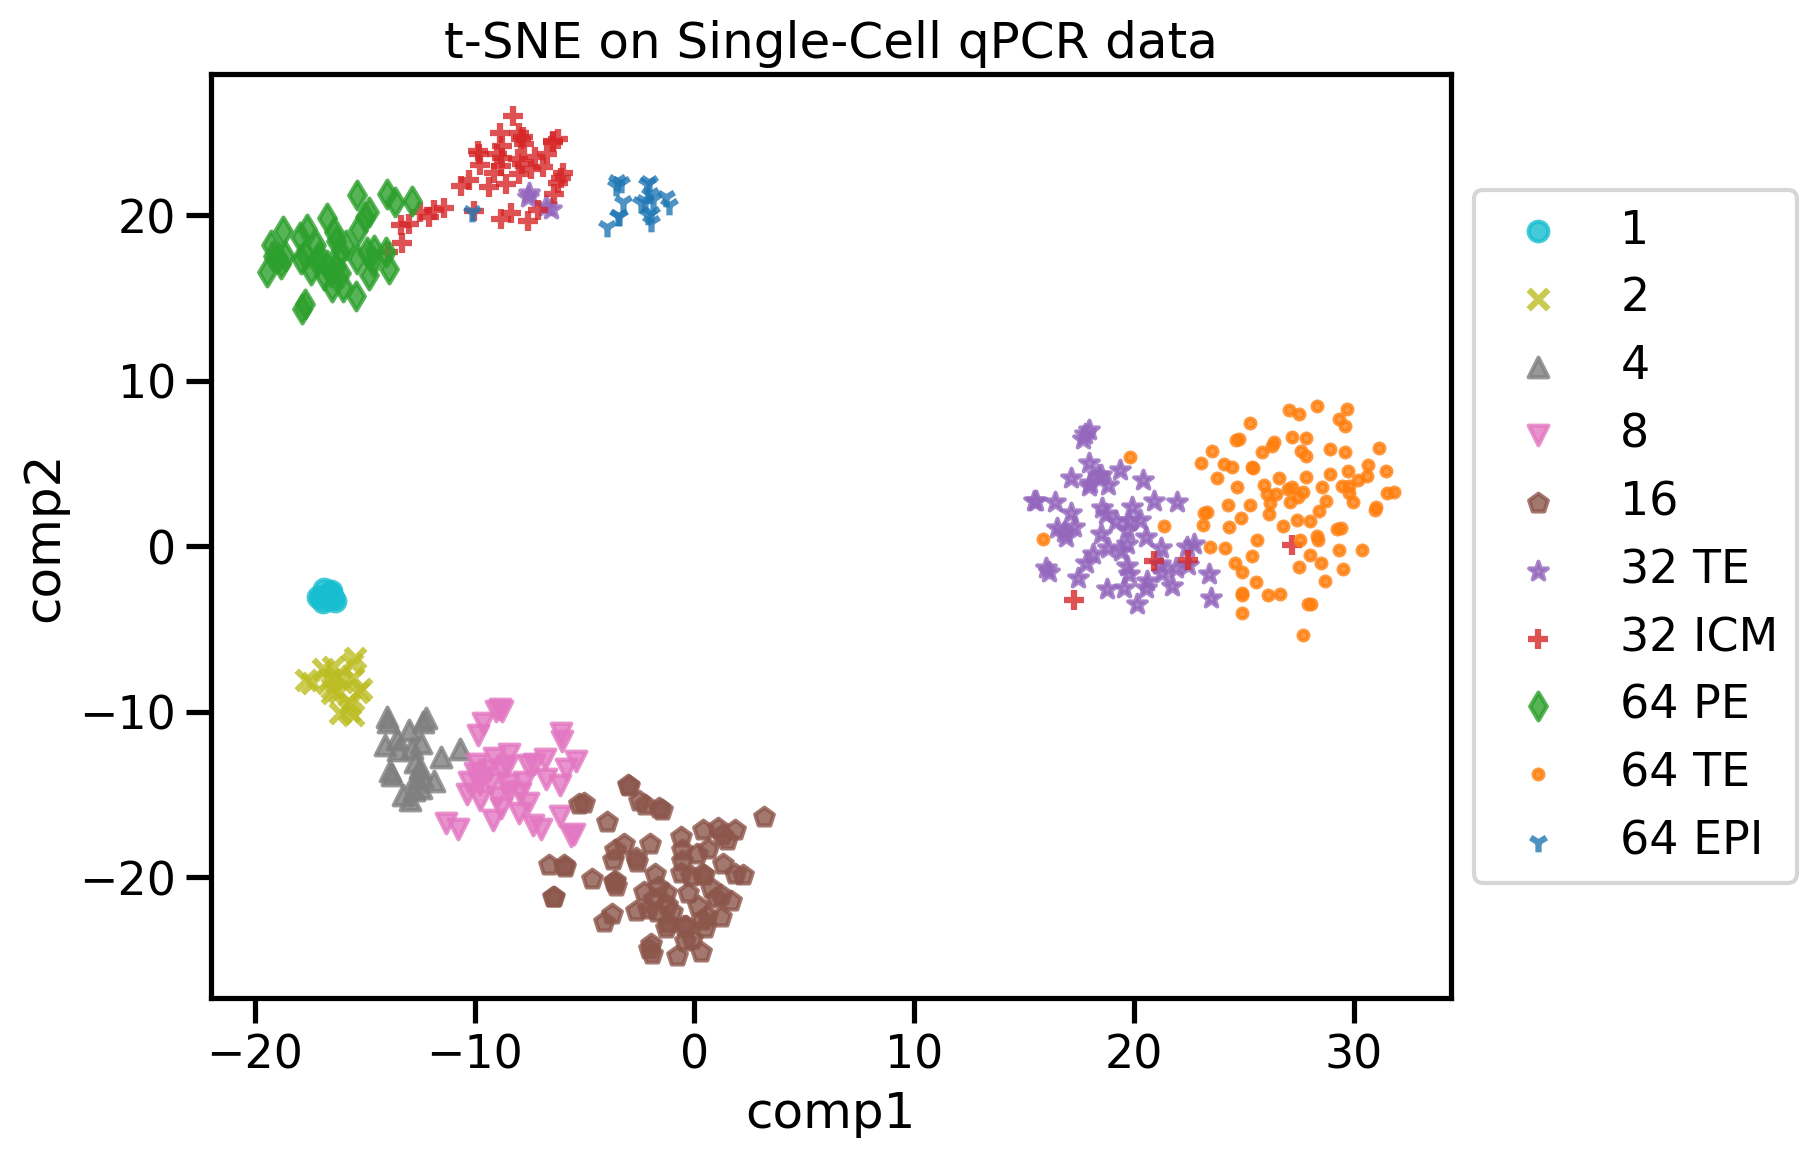

In [14]:
#@title t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(data)

plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

for i, label in enumerate(labels):
    X_i = X_tsne[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], marker=markers[i], alpha=0.8, s=50, label=label)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("comp1")
plt.ylabel("comp2")
plt.title("t-SNE on Single-Cell qPCR data")

In [15]:
%load_ext watermark
%watermark --iversions

gpytorch  : 1.5.1
matplotlib: 3.10.0
pandas    : 2.2.2
tqdm      : 4.67.1
seaborn   : 0.13.2
torch     : 2.8.0+cu126
sklearn   : 1.6.1

